# Image Compression

The goal of this notebook is to explore image compression using various forms of matrix decomposition.

In [78]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


Here is the sample image we will be using for all our experiments in this notebook:

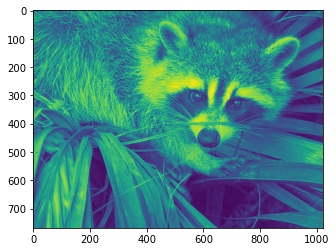

In [3]:
face = misc.face()
data = face[:,:,0] / 255
plt.imshow(data);

In [76]:
data.shape

(768, 1024)

## decompositions

First we use a canned PCA routine as a baseline for image compression:

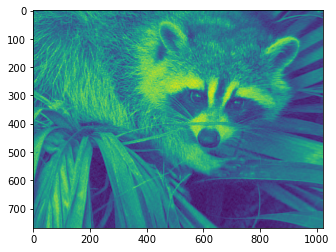

In [4]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
approx = pca.inverse_transform(pca.fit_transform(data))
plt.imshow(approx);

The resulting image is almost indistinguishable from the original.

Next, we illustrate some of the image compression methods we have implemented:

In [80]:
def plot_approx_array(rank):
    fig, ax = plt.subplots(1,5, figsize=(15,2.5))

    # Original Data
    ax[0].imshow(data)
    ax[0].set_xlabel('Original data')

    # Singular Value Decomposition
    start = perf_counter()
    ax[1].imshow(svd_rank_k(data, rank))
    ax[1].set_xlabel('Singular Value Decomposition')
    print(f'SVD: {perf_counter() - start}')

    # Randomized SVD
    start = perf_counter()
    ax[2].imshow(random_svd_rank_k(data, rank))
    ax[2].set_xlabel('Randomized SVD')
    print(f'RSVD: {perf_counter() - start}')

    # Interpolative Decomposition
    start = perf_counter()
    ax[3].imshow(id_rank_k(data, rank))
    ax[3].set_xlabel('Interpolative Decomposition')
    print(f'ID: {perf_counter() - start}')

    # Randomized ID
    start = perf_counter()
    ax[4].imshow(random_id_rank_k(data, rank))
    ax[4].set_xlabel('Randomized ID')
    print(f'RID: {perf_counter() - start}')

    plt.suptitle(f'Rank-{rank} Approximations')

SVD: 0.18899079999755486
RSVD: 0.015450099999725353
ID: 0.08520720000160509
RID: 0.01864719999866793


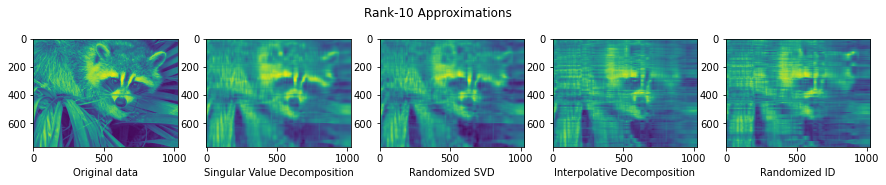

In [81]:
plot_approx_array(10)

SVD: 0.1929749000009906
RSVD: 0.03382639999836101
ID: 0.08119960000112769
RID: 0.019567600000300445


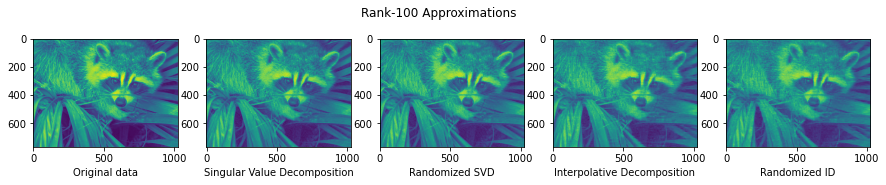

In [84]:
plot_approx_array(100)

We can see that a higher-rank matrix approximation leads to a more faithful image approximation. A higher-rank matrix holds more meaningful data than a lower-rank one, since it has more independent columns/rows.

We also see that the randomized methods are comparable to their deterministic variants in quality, while being much more efficient! This is a prime example of the benefits of using randomness in algorithms.

## calculate statistics

Here, we vary the rank k of the approximation and analyze the quality of the resulting compressed images:

In [72]:
k_domain = np.concatenate(([1, 2, 5, 10], np.arange(20, 400, step=40), [400, 420, 440]))


error_svd = np.empty(k_domain.shape[0])
error_id = np.empty(k_domain.shape[0])

for i,val in enumerate(tqdm(k_domain)):
    error_svd[i] = np.linalg.norm(data - svd_rank_k(data, val)) / np.linalg.norm(data)
    error_id[i] = np.linalg.norm(data - id_rank_k(data, val)) / np.linalg.norm(data)


iterations = 10

error_random_svd = np.empty((7,k_domain.shape[0]))
error_random_id = np.empty((7, k_domain.shape[0]))

for i,val in enumerate(tqdm(k_domain)):
    err_rsvd = np.empty(iterations)
    err_rid = np.empty(iterations)

    for j in range(iterations):
        err_rsvd[j] = np.linalg.norm(data - random_svd_rank_k(data, val)) / np.linalg.norm(data)
        err_rid[j] = np.linalg.norm(data - random_id_rank_k(data, val)) / np.linalg.norm(data)
    
    error_random_svd[0][i] = np.quantile(err_rsvd, 0.25)
    error_random_svd[1][i] = np.median(err_rsvd)
    error_random_svd[2][i] = np.quantile(err_rsvd, 0.75)
    error_random_svd[3][i] = np.mean(err_rsvd)
    error_random_svd[4][i] = np.std(err_rsvd)
    error_random_svd[5][i] = np.min(err_rsvd)
    error_random_svd[6][i] = np.max(err_rsvd)

    error_random_id[0][i] = np.quantile(err_rid, 0.25)
    error_random_id[1][i] = np.median(err_rid)
    error_random_id[2][i] = np.quantile(err_rid, 0.75)
    error_random_id[3][i] = np.mean(err_rid)
    error_random_id[4][i] = np.std(err_rid)
    error_random_id[5][i] = np.min(err_rid)
    error_random_id[6][i] = np.max(err_rid)

100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


## display results

Text(0.5, 1.0, 'Error in Various Approximations')

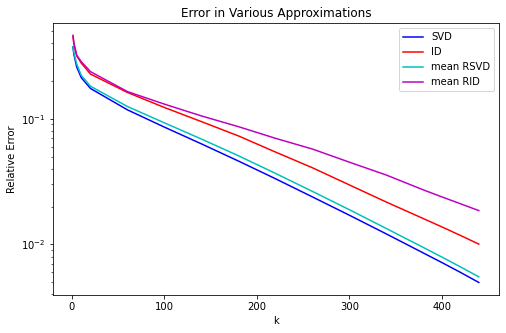

In [73]:
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(k_domain, error_svd, c='b', label='SVD')
ax.plot(k_domain, error_id, c='r', label='ID')
ax.plot(k_domain, error_random_svd[3], c='c', label='mean RSVD')
ax.plot(k_domain, error_random_id[3], c='m', label='mean RID')
ax.set_xlabel('k')
ax.set_ylabel('Relative Error')
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_title('Error in Various Approximations')

Note that this graph is logarithmically scaled, so the approximation really is quite good. For example, a rank-100 approximation of the (at most) 768-rank original image is about 90% accurate.

In [74]:
level = 3
k_domain = k_domain[-level:]
error_random_svd = error_random_svd[:,-level:]
error_random_id = error_random_id[:,-level:]

Text(0.5, 1.0, "Randomized ID 'continuous boxplot'")

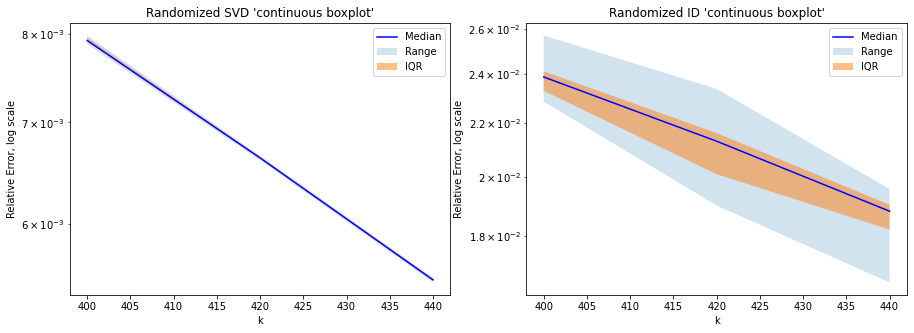

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(k_domain, error_random_svd[1], c='b', label='Median')
ax[0].fill_between(k_domain, error_random_svd[6],error_random_svd[5], alpha=0.2, label='Range')
ax[0].fill_between(k_domain, error_random_svd[2],error_random_svd[0], alpha=0.5, label='IQR')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error, log scale')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Randomized SVD \'continuous boxplot\'')

ax[1].plot(k_domain, error_random_id[1], c='b', label='Median')
ax[1].fill_between(k_domain, error_random_id[6],error_random_id[5], alpha=0.2, label='Range')
ax[1].fill_between(k_domain, error_random_id[2],error_random_id[0], alpha=0.5, label='IQR')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized ID \'continuous boxplot\'')

This graph lets us see the difference in accuracy and precision between RSVD and RID.

The accuracy of RSVD is better than that of RID, but what is arguably more noteworthy is the remarkable precision of RSVD. The RID plot has some level of variance, but in the RSVD plot, we can barely even see the faint outline of the range -- that's how precise it is.

#### Check out our other notebooks to see more examples of random projection in action!